<a href="https://colab.research.google.com/github/datawiz1984/malaria-model/blob/master/malaria_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Colab Jupyter Note book for the Implementation of a Malaria Diagnostic Tool.**
By Musa Mikail
2019.

The Aim of the Book is to Train a Binary Classifer that will be used in diagonising malaria using images of slides captured froma  thin-smear test.

The Implementation will be progressed thus:
1. Download the Malaria Dataset from https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip.
2. Explore and analyse the data to identify the key features and ascertain additional pre-processing requirments before progressing with training.
3. Pre-process the data - Including resizing and aurgumentation
4. Implementation and training of a Convolution Neural Network Binary classifier
5. Implement a vanilla ANN for the purpose of benchmarking and pefromance assessment
6. Implement a Canny Edge detection method for counting and segmentation of cells from images passed for inference (not related to model training)
7. Save and export model for deployment.

**1. Download the Malaria Dataset from https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip.**

In [1]:
#Download data from the website of US national library of medicine
import os

if not os.path.isdir('/datasets/malaria/'):
  os.makedirs('/datasets/malaria/')

!wget --no-check-certificate "https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip" \
-O /datasets/malaria/cell_images.zip

--2019-07-24 13:49:16--  https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip
Resolving ceb.nlm.nih.gov (ceb.nlm.nih.gov)... 130.14.52.15, 2607:f220:41e:7052::15
Connecting to ceb.nlm.nih.gov (ceb.nlm.nih.gov)|130.14.52.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘/datasets/malaria/cell_images.zip’

/datasets/malaria/c 100%[===================>] 337.08M  43.5MB/s    in 6.2s    

2019-07-24 13:49:22 (54.7 MB/s) - ‘/datasets/malaria/cell_images.zip’ saved [353452851/353452851]



In [2]:
import zipfile

zip_path = '/datasets/malaria/cell_images.zip'
print('Unzipping file....')
malaria_zip = zipfile.ZipFile(zip_path,'r')
malaria_zip.extractall('/datasets/malaria/')
malaria_zip.close()
print('Done!!!')

Unzipping file....
Done!!!


**Explore and analyse the data **

In [3]:
#Diectory with our training parasitized cells pictures
train_parasitized_dir = '/datasets/malaria/cell_images/Parasitized'

#Diectory with our training Uninfected cells pictures
train_uninfected_dir = '/datasets/malaria/cell_images/Uninfected'

train_parasitized_names = os.listdir(train_parasitized_dir)
train_uninfected_names = os.listdir(train_uninfected_dir)
print('total training parasitized images:', len(os.listdir(train_parasitized_dir)))
print('total training Uninfected images:', len(os.listdir(train_uninfected_dir)))

total training parasitized images: 13780
total training Uninfected images: 13780


File skipped: /datasets/malaria/cell_images/Parasitized/Thumbs.db
File skipped /datasets/malaria/cell_images/Uninfected/Thumbs.db
Modal Height of Image: 130
Modal Width of Image: 130
Stand. Dev Height of Image: 20.61927561732627
Stand. Dev Width of Image: 20.015585545533767


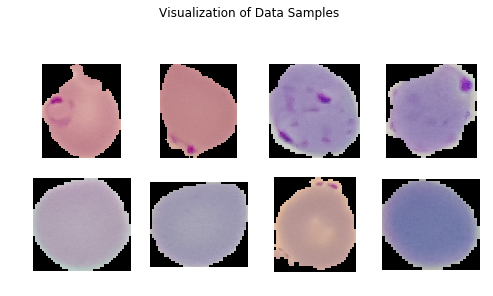

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


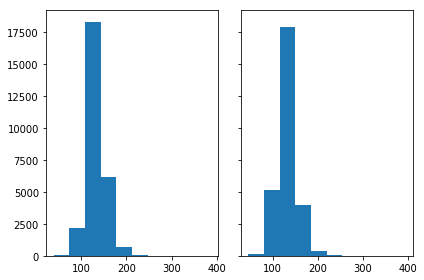

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt1
import matplotlib.pyplot as plt2
import matplotlib.image as mpimg
from PIL import Image
from statistics import mode,pstdev

#Get the dimensions of the images
img_heights=[]
img_widths=[]

#Index for image iteration
pic_print_index = 4


#parameters for 2X2 graphs

nrows = 4
ncols = 4


# Set up matplotlib fig, and size it to fit 2X2 pics
fig1 = plt1.gcf()
fig1.set_size_inches(ncols * 2, nrows * 2)
fig1.suptitle('Visualization of Data Samples')


next_parasitized_pix = [os.path.join(train_parasitized_dir, fname) 
                for fname in train_parasitized_names]

next_Uninfected_pix = [os.path.join(train_uninfected_dir, fname) 
                for fname in train_uninfected_names]

for f in next_parasitized_pix:
  try:
    img = Image.open(str(f))
    img_heights.append(img.height)
    img_widths.append(img.width)
  except:
    print("File skipped: {}".format(str(f)))
    
for f in next_Uninfected_pix:
  try:
    img = Image.open(str(f))
    img_heights.append(img.height)
    img_widths.append(img.width)
  except:
    print("File skipped {}".format(str(f)))

#print(img_heights[0])

  
#print sample images of both classes in the training data

for i, img_path in enumerate(next_parasitized_pix[0:pic_print_index]+next_Uninfected_pix[0:pic_print_index]):
  # Set up subplot; subplot indices start at 1
  sp = plt1.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  img = mpimg.imread(img_path)
  plt1.imshow(img)

  
fig1, axs = plt2.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(img_heights)
axs[1].hist(img_widths)
  
#Plot distribution of Height and width
print("Modal Height of Image: {}".format(mode(img_heights)))
print("Modal Width of Image: {}".format(mode(img_widths)))
print("Stand. Dev Height of Image: {}".format(pstdev(img_heights)))
print("Stand. Dev Width of Image: {}".format(pstdev(img_widths)))

***Observations from Data Exploration:***
1. There are a total of 27,560 Images in the training dataset
2. The Training data is balanced (equal number of classes), and Accuracy will be a good metrics for measuring performance during training.
3. There is a variations in the shapes of the images, with 130X130 been the most common occurence with variance of ccc observed.

**3. Pre-process the data - Including resizing, and Aurgumentation** **bold text**

In [5]:
#Data Processing using the image generator
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

#All images will be rescaled by 1./255 for uniformity

image_gen= ImageDataGenerator(rescale = 1./255,
                             validation_split = 0.25,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True)

#Flow the whole data in batches of 128 using data_gen generator

train_data = image_gen.flow_from_directory(
    '/datasets/malaria/cell_images/',
     target_size = (130,130),
     batch_size = 128,
     class_mode = 'binary')

test_data = image_gen.flow_from_directory(
    '/datasets/malaria/cell_images/',
     target_size = (130,130),
     batch_size = 128,
     class_mode = 'binary')

Found 27558 images belonging to 2 classes.
Found 27558 images belonging to 2 classes.


In [6]:
#Build a simple vanilla Multi-layer perceptron
#This model will be used for benchmarking
transformVanilla = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(130, 130, 3)),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

W0724 13:49:39.042227 139946147551104 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
#Assemble a simple three stage CNN.
transformLightCNN = tf.keras.models.Sequential([
    #Stage 1
    tf.keras.layers.Conv2D(16, (3,3), strides=(1,1), activation = 'relu', input_shape = (130,130,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    #Stage 2
    tf.keras.layers.Conv2D(32, (3,3), strides=(1,1), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #Stage 3
    tf.keras.layers.Conv2D(64, (3,3), strides=(1,1), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #Fully Connected Section
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [0]:
#Implement Training Callbacks

vanilla_train_loss=[]
vanilla_train_acc = []
vanilla_validation_loss = []
vanilla_validation_acc = []
light_train_loss=[]
light_train_acc = []
light_validation_loss = []
light_validation_acc = []


class vanillaCallback(tf.keras.callbacks.Callback):
  def on_train_batch_end(self, epoch, logs={}):
    vanilla_train_loss.append(logs.get('loss'))
    vanilla_train_acc.append(logs.get('acc'))
    vanilla_validation_loss.append(logs.get('val_loss'))
    vanilla_validation_acc.append(logs.get('val_Acc'))


class lightCallback(tf.keras.callbacks.Callback):
  def on_train_batch_end(self, epoch, logs={}):
    light_train_loss.append(logs.get('loss'))
    light_train_acc.append(logs.get('acc'))
    light_validation_loss.append(logs.get('val_loss'))
    light_validation_acc.append(logs.get('val_Acc'))

    
vanilla_callbacks = vanillaCallback()
Light_callbacks = lightCallback()


In [9]:
#Now we compile the model using an Adam Optimiuzer
#and a binary_crossentropy loss function

transformVanilla.compile(loss = 'binary_crossentropy',
                    optimizer = 'adam',
                    metrics = ['acc'])

transformLightCNN.compile(loss = 'binary_crossentropy',
                    optimizer = 'adam',
                    metrics = ['acc'])

W0724 13:49:39.519643 139946147551104 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
#Training of the Vanilla MLP Classifier
%%timeit
transformerVanilla = transformVanilla.fit_generator(
            train_data,
            callbacks=[vanilla_callbacks],
            validation_data=test_data,
            validation_steps=8,
            epochs=10,
            verbose=1)

Epoch 1/10
216/216 [==============================] - 166s 769ms/step - loss: 5.2223 - acc: 0.5546 - val_loss: 1.0006 - val_acc: 0.5576
Epoch 2/10
216/216 [==============================] - 165s 765ms/step - loss: 1.1583 - acc: 0.5566 - val_loss: 0.8099 - val_acc: 0.5918
Epoch 3/10
216/216 [==============================] - 151s 700ms/step - loss: 0.7567 - acc: 0.5943 - val_loss: 0.7542 - val_acc: 0.5830
Epoch 4/10
216/216 [==============================] - 154s 714ms/step - loss: 0.7192 - acc: 0.5993 - val_loss: 0.6522 - val_acc: 0.6240
Epoch 5/10
216/216 [==============================] - 157s 727ms/step - loss: 0.6881 - acc: 0.6124 - val_loss: 0.6529 - val_acc: 0.6348
Epoch 6/10
216/216 [==============================] - 149s 689ms/step - loss: 0.6898 - acc: 0.6017 - val_loss: 0.7211 - val_acc: 0.5400
Epoch 7/10
216/216 [==============================] - 149s 690ms/step - loss: 0.6563 - acc: 0.6204 - val_loss: 0.6513 - val_acc: 0.6211
Epoch 8/10
216/216 [============================

In [11]:
#Training of the Tuned Light architecture Classifier
%%timeit
transformerLightCNN = transformLightCNN.fit_generator(
            train_data,
            callbacks=[Light_callbacks],
            validation_data=test_data,
            validation_steps=8,
            epochs=10,
            verbose=1)

Epoch 1/10
216/216 [==============================] - 169s 781ms/step - loss: 0.6371 - acc: 0.6227 - val_loss: 0.3850 - val_acc: 0.8584
Epoch 2/10
216/216 [==============================] - 160s 743ms/step - loss: 0.2800 - acc: 0.8910 - val_loss: 0.2189 - val_acc: 0.9209
Epoch 3/10
216/216 [==============================] - 159s 737ms/step - loss: 0.2388 - acc: 0.9124 - val_loss: 0.1943 - val_acc: 0.9336
Epoch 4/10
216/216 [==============================] - 156s 720ms/step - loss: 0.2269 - acc: 0.9203 - val_loss: 0.1874 - val_acc: 0.9307
Epoch 5/10
216/216 [==============================] - 157s 728ms/step - loss: 0.2141 - acc: 0.9268 - val_loss: 0.1670 - val_acc: 0.9453
Epoch 6/10
216/216 [==============================] - 151s 700ms/step - loss: 0.2098 - acc: 0.9268 - val_loss: 0.1760 - val_acc: 0.9443
Epoch 7/10
216/216 [==============================] - 151s 698ms/step - loss: 0.1993 - acc: 0.9308 - val_loss: 0.1823 - val_acc: 0.9404
Epoch 8/10
216/216 [============================

In [12]:
#Summary of Built models
transformVanilla.summary()
transformLightCNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 50700)             0         
_________________________________________________________________
dense (Dense)                (None, 1000)              50701000  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1001      
Total params: 50,702,001
Trainable params: 50,702,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
______________________

In [0]:
def cells_counter(pt):
  from keras.preprocessing import image
  import cv2
  from google.colab.patches import cv2_imshow
  import numpy as np
  
  count_inf = 0
  count = 0
  
  slide = cv2.imread(str(pt))
  gray=cv2.cvtColor(slide,cv2.COLOR_BGR2GRAY)
  slide_edged=cv2.Canny(gray, 30, 200, 3, L2gradient=True)
  cv2.waitKey(0)
  _, contours, hierarchy=cv2.findContours(slide_edged,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
  cv2.waitKey(0)
  
  #use -1 as the 3rd parameter to draw all the contours
  cv2.drawContours(slide,contours,-1,(25,0,0),1)
  cv2_imshow(slide)
  
  cv2.waitKey(0)
  cv2.destroyAllWindows()
  print('Total contours', str(len(contours)))
  
  if not os.path.isdir('./temp_cells'):
    os.makedirs('./temp_cells')
  
  temp_file = "./temp_cells/current_file"
  
  for c in contours:
    x,y,w,h = cv2.boundingRect(c)
    if (w/h > 0.8 and w/h < 1.1):
      cell_img=slide[y:y+h,x:x+w]
      cv2.imwrite(temp_file + '.png', cell_img)
      img = image.load_img(temp_file + '.png', target_size=(130, 130))
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
      cell = np.vstack([x])
      health = transformLightCNN.predict(cell, batch_size=10)
      if health[0] < 0.5:
        print("Is Infected")
        count_inf = count_inf + 1
      #else:
      #  print("Is not Infected")
      print('prediction is {}'.format(health[0]))
      cell_temp = cv2.imread(temp_file + '.png')
      cv2_imshow(cell_temp)
      cv2.waitKey(1)
  return count_inf, len(contours)

In [0]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  path = '/content/' + fn
  infected,total = cells_counter(path)
  print (str(infected/total))

In [0]:
print((vanilla_train_loss))

Text(0.5, 0, 'Training Cycle')

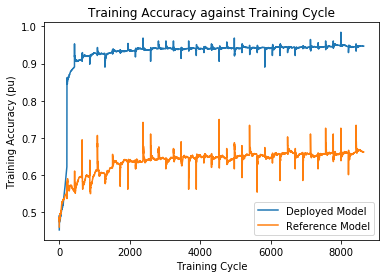

In [36]:
#print((vanilla_train_loss))
#print((vanilla_train_acc))
#print((light_train_loss))
#print((light_train_acc))

from matplotlib import pyplot as plt3
lightx = range(len(light_train_acc))
vanillax = range(len(vanilla_train_acc))
plt3.plot(lightx,light_train_acc,label='Deployed Model')
plt3.plot(vanillax,vanilla_train_acc,label='Reference Model')
plt3.legend()
plt3.title('Training Accuracy against Training Cycle')
plt3.ylabel('Training Accuracy (pu)')
plt3.xlabel('Training Cycle')
#Save the moels

In [0]:


transformLightCNN.save('transformLightCNN.h5')
transformVanilla.save('transformVanilla.h5')